In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

import torch
from torch import nn, optim
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm

In [2]:
!nvidia-smi

Sun Jul 20 16:41:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
df = pd.read_csv("../Dataset/gpreviews_2.csv")

In [4]:
df.head()

,reviewId,text,score,sentiment,labels
0,7793317c-ab30-4e9b-abcd-6e3df0a5d440,Sony Liv. one of best experiences. I changed m...,1,Positive,"['user experience', 'features']"
1,c2617457-7693-45f0-9142-079b250ef22f,Horrible app honestly for such a rich company ...,0,Negative,"['user experience', 'cost', 'performance', 'fe..."
2,dc96ac81-1311-4018-acee-588b79659125,This app very good and useful. For watching Ko...,1,Positive,"['features', 'user experience']"
3,5445cb50-f16d-4a5a-8b03-66909aa33bb8,Suddenly signed out of my account for no reaso...,0,Negative,"['login problems', 'data loss', 'user experien..."
4,8d86a93f-538d-451c-9243-f364227e3976,I've found everything here to be of my liking,1,Positive,"['features', 'user experience']"


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("../Models/roberta_tokenizer")
model = AutoModel.from_pretrained("../Models/roberta_base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
token_len = []
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length = 512)
    token_len.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<Axes: ylabel='Density'>

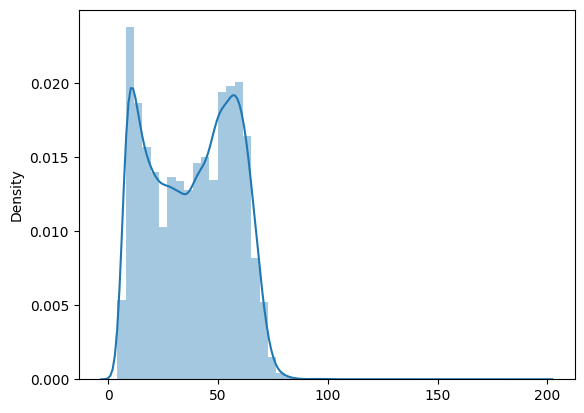

In [7]:
sns.distplot(token_len)

In [8]:
max_length = 100
class GPReview(Dataset):
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__ (self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])

        encoding = self.tokenizer.encode_plus(review,
                                             max_length = self.max_len,
                                             add_special_tokens=True,
                                             pad_to_max_length = True,
                                             truncation = True,
                                             return_attention_mask = True,
                                             return_token_type_ids = False,
                                             return_tensors = "pt")
        
        return{
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "targets": torch.tensor(self.target[item], dtype = torch.long)
        }

In [9]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 42)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = 42)

In [10]:
df_train.shape, df_test.shape, df_val.shape

((23098, 5), (4950, 5), (4950, 5))

In [11]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReview(review = df.text.to_numpy(), 
                  target = df.score.to_numpy(),
                 tokenizer = tokenizer,
                 max_len = max_len)

    return DataLoader(ds, batch_size = batch_size)
    

In [12]:
batch_size = 32
train_data_loader = create_data_loader(df_train, tokenizer, max_length, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_length, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_length, batch_size)

In [13]:
data = next(iter(train_data_loader))

In [14]:
data.keys()

dict_keys(['input_ids', 'attention_mask', 'targets'])

In [15]:
data["input_ids"].shape

torch.Size([32, 100])

In [16]:
data["input_ids"]

tensor([[    0,   133,  7465,  ...,     1,     1,     1],
        [    0, 17485,  7229,  ...,     1,     1,     1],
        [    0, 18064,    34,  ...,     1,     1,     1],
        ...,
        [    0,  6785,  2129,  ...,     1,     1,     1],
        [    0,   100,  1871,  ...,     1,     1,     1],
        [    0,   771, 27407,  ...,     1,     1,     1]])

In [17]:
data["attention_mask"].shape

torch.Size([32, 100])

In [18]:
data["attention_mask"]

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [20]:
import torch.nn as nn
from transformers import AutoModel

class Sentiment_Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Sentiment_Classifier, self).__init__()
        self.roberta = AutoModel.from_pretrained("FacebookAI/roberta-base")
        
        for param in self.roberta.parameters():
            param.requires_grad = False

        for layer in self.roberta.encoder.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True
                
        self.drop = nn.Dropout(p=0.1)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # [CLS] token representation
        output = self.drop(pooled_output)
        output = self.out(output)
        return output


In [21]:
device = "cuda"

In [22]:
model = Sentiment_Classifier(n_classes = 2)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentiment_Classifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [23]:
epochs = 3
optimizer = AdamW(model.parameters(), lr= 2e-5, correct_bias = False)

total_steps = len(train_data_loader)*epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0.15 * total_steps,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [24]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    preds = torch.argmax(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(epochs):
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss: {train_loss:.2f} \naccuracy: {train_acc*100:.2f}%')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val loss: {val_loss:.2f} \naccuracy: {val_acc*100:.2f}%')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Models/sentiment_model/best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss: 0.30 
accuracy: 86.84%
Val loss: 0.22 
accuracy: 92.38%

Epoch 2/3
----------
Train loss: 0.21 
accuracy: 92.12%
Val loss: 0.21 
accuracy: 92.42%

Epoch 3/3
----------
Train loss: 0.20 
accuracy: 92.50%
Val loss: 0.21 
accuracy: 92.67%

CPU times: user 5min 14s, sys: 2.1 s, total: 5min 16s
Wall time: 5min 17s


In [27]:
print(f"Best Validation Accuracy: {best_accuracy.item()*100:.2f}%")

Best Validation Accuracy: 92.67%


In [28]:
model = torch.load('best_model.pth')
model.to(device)

Sentiment_Classifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [29]:
def get_predictions(model, data_loader):
    model = model.eval()

    predictions = []
    prediction_probs =[]
    real_values = []

    with torch.no_grad():
        for d in data_loader:
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)
          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          predictions.extend(preds)
          prediction_probs.extend(outputs)
          real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return predictions, prediction_probs, real_values          

In [30]:
y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [31]:
test_accuracy = (y_pred==y_test).sum().item()/len(df_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Accuracy: 92.00%


In [32]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2457
           1       0.94      0.90      0.92      2493

    accuracy                           0.92      4950
   macro avg       0.92      0.92      0.92      4950
weighted avg       0.92      0.92      0.92      4950



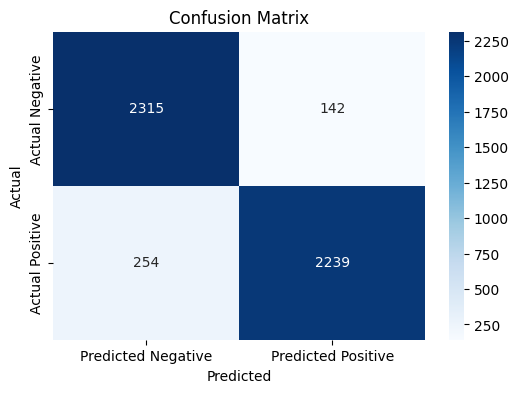

In [33]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


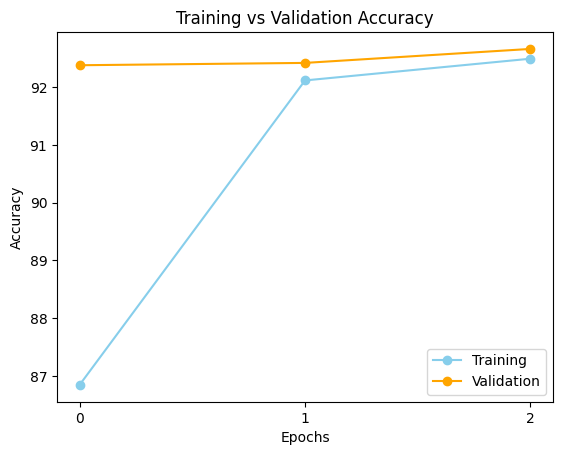

In [34]:
data1 = np.array([x.to("cpu").detach().numpy() * 100 for x in history["train_acc"]])
data2 = np.array([x.to("cpu").detach().numpy() * 100 for x in history["val_acc"]])

plt.plot(data1, color="skyblue", label="Training", marker = "o")
plt.plot(data2, color="orange", label="Validation", marker = "o")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")

plt.xticks(range(len(data1)))

plt.legend()
plt.show()

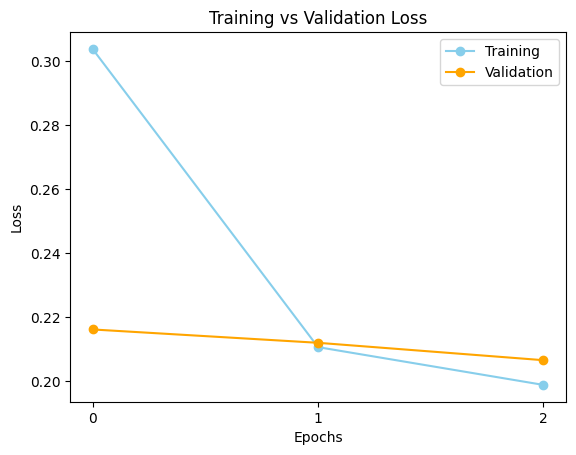

In [35]:
data1 = history["train_loss"]
data2 = history["val_loss"]

plt.plot(data1, color="skyblue", label="Training", marker = "o") 
plt.plot(data2, color="orange", label="Validation", marker = "o")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")

plt.xticks(range(len(data1)))

plt.legend()
plt.show()

In [36]:
def get_sentiment(prompt, model = model):
    model.to("cpu")
    model.eval()
    encoding = tokenizer.encode_plus(prompt, 
                                     max_length = max_length, 
                                     pad_to_max_length = True, 
                                     return_token_type_ids = False, 
                                     truncation = True,
                                    return_tensors = "pt")
    output = model(encoding["input_ids"], encoding["attention_mask"])
    softmax = nn.Softmax()
    output = softmax(output)
    value, preds = torch.max(output, dim = 1)

    if preds.item() == 1:
        print(f"Positive: {value.item()*100:.2f}%")
    else:
        print(f"Negative: {value.item()*100:.2f}%")

In [37]:
prompt = "I am disappointed with the app; its inconsistent performance makes it unreliable."
get_sentiment(prompt)

Negative: 94.78%
